In [1]:
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm

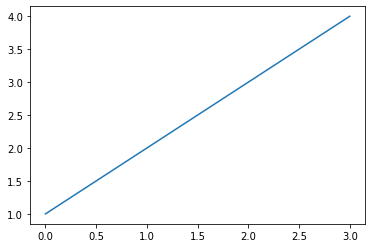

In [2]:
# For some reason I have to plot once before other libraries :(
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import spacy

import numpy as np
import math

from torch.utils.tensorboard import SummaryWriter
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

from models import CustTransformer

import itertools

# Helper functions :)
from helper import translate_sentence, bleu

from tqdm.notebook import tqdm

from torch.nn.functional import pad

import random

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
spacy_eng = spacy.load('en_core_web_sm')
spacy_ger = spacy.load('de_core_news_sm')

def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

def tokenize_ger(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]

english = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")
german = Field(sequential=True, use_vocab=True, tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")

train_data, validation_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                         fields=(german, english))

english.build_vocab(train_data, max_size=10000, min_freq=2)
german.build_vocab(train_data, max_size=10000, min_freq=2)

In [6]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = CustTransformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        
        # Dropping dropout here so I can pull the output from this layer during training
        embed_src = (self.src_word_embedding(src) + self.src_position_embedding(src_positions)).to(self.device)
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))).to(self.device)
        
        src_padding_mask = self.make_src_mask(src).to(self.device)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
                
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        ).to(self.device)
        
        out = self.fc_out(out).to(self.device)
        return out

In [7]:
def make_src_mask(src):
    src_mask = src.transpose(0, 1) == src_pad_idx
    return src_mask.to(device)

def make_attn_mask(inp_data, k, q, bsz):
    key_padding_mask = make_src_mask(inp_data)

    attn_mask = None

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.shape == (bsz, src_len), \
            f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
        key_padding_mask = key_padding_mask.view(bsz, 1, 1, src_len).   \
            expand(-1, num_heads, -1, -1).reshape(bsz * num_heads, 1, src_len)
        if attn_mask is None:
            attn_mask = key_padding_mask

    if attn_mask is not None and attn_mask.dtype == torch.bool:
        new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
        new_attn_mask.masked_fill_(attn_mask, float("-inf"))
        attn_mask = new_attn_mask
        
    return attn_mask

##### HELPER FUNCTION FOR FEATURE EXTRACTION
def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

In [8]:
# We're ready to define everything we need for training our Seq2Seq model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {torch.cuda.get_device_name(0)}")

# Training Hyperparameters
num_epochs = 30
learning_rate = 3e-4
batch_size = 32

# Model Hyperparameters
src_vocab_size = len(german.vocab)
trg_vocab_size = len(english.vocab)
embedding_size = 512
num_heads = 4
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 50
forward_expansion = 2048
src_pad_idx = english.vocab.stoi["<pad>"]


# Regularization term, right now its super high
lam = 1.0

static_k = None
static_v = None

Current Device: NVIDIA GeForce GTX 1080 Ti


In [9]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data, test_data),
    batch_size=batch_size,
    sort_within_batch = True,
    sort_key = lambda x: len(x.src),
    device = device)

In [10]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [11]:
##### REGISTER HOOK
# Inputs to the 3 Encoder Layers
model.src_word_embedding.register_forward_hook(get_features('E1a'))
model.src_position_embedding.register_forward_hook(get_features('E1b'))
model.transformer.encoder.layers[0].register_forward_hook(get_features('E2'))
model.transformer.encoder.layers[1].register_forward_hook(get_features('E3'))

In [12]:
def calc_encoder_reg_error(batch_size):
    
    reg_penalty = torch.tensor(1e-8).to(device) 
    epsilon = 1e-8
    
    # First we pull in the weights for each attention matricies for each layer
    in_weight1 = model.transformer.encoder.layers[0].self_attn.in_proj_weight.to(device)
    in_bias1 = model.transformer.encoder.layers[0].self_attn.in_proj_bias.to(device)

    in_weight2 = model.transformer.encoder.layers[1].self_attn.in_proj_weight.to(device)
    in_bias2 = model.transformer.encoder.layers[1].self_attn.in_proj_bias.to(device)

    in_weight3 = model.transformer.encoder.layers[2].self_attn.in_proj_weight.to(device)
    in_bias3 = model.transformer.encoder.layers[2].self_attn.in_proj_bias.to(device)
    
    weights = [in_weight1, in_weight2, in_weight3]
    biasses = [in_bias1, in_bias2, in_bias3]
    
    # for each sentence in batch
    for m in range(batch_size):
        
        # for each layer in encoder
        for l in range(num_encoder_layers):
            
            if l == 0:
                x = INPUTS[0]+INPUTS[1]
            else:
                x = INPUTS[l+1]
                        
            tgt_len, bsz, embed_dim = x.shape
            head_dim = embed_dim // num_heads

            q, k, v = F._in_projection_packed(x, x, x, weights[l], biasses[l])
            q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
            k = k.contiguous().view(k.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
            v = v.contiguous().view(v.shape[0], bsz * num_heads, head_dim).transpose(0, 1)
            
            attn_mask = make_attn_mask(inp_data, k, q, bsz=x.shape[1])

            _, attn = F._scaled_dot_product_attention(q, k, v, attn_mask = attn_mask, dropout_p=0)
            
            for i, j in list(itertools.combinations('0123', 2)):
                head1 = int(i)
                head2 = int(j)

                # Modified Bhattacharyya Coefficient
                reg_penalty += torch.mean(
                               torch.sum(
                               torch.sqrt(
                               torch.mul(attn[head1+(4*m)], attn[head2+(4*m)]) + epsilon), 1)) / 6 
    
    reg_penalty = reg_penalty/batch_size
                    
    return reg_penalty

In [13]:
sentence = "ein pferd geht unter einer brücke neben einem boot."

losses = []
CELosses = []
regLosses = []
bleuScores = []

# Place holder for hooks
features = {}

for epoch in range(num_epochs):
    print(f"[Epoch {epoch + 1} / {num_epochs}]")

    model.eval()
    translated_sentence = translate_sentence(model, sentence, german, english, device, max_length=50)
    print(f"Translated example sentence: \n {translated_sentence}")
        
    model.train()   
    for batch_idx, batch in tqdm(enumerate(train_iterator)):       
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)
        
        # Place holder for hooks
        # placeholders
        INPUTS = []
        features = {}

        # Forward prop
        output = model(inp_data, target[:-1, :])
        
        # Store the inputs to the Encoder layers
        INPUTS.append(features['E1a'])
        INPUTS.append(features['E1b'])
        INPUTS.append(features['E2'])
        INPUTS.append(features['E3'])
    


        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin.
        # Let's also remove the start token while we're at it
        output = output.reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()

        reg_penalty = torch.tensor(0)
        cross_entropy_loss = criterion(output, target)
        
        #####################################################################################
        # We will calculate the multi head attention matricies here and push for DIVERSITY! #
        #####################################################################################
        reg_penalty = calc_encoder_reg_error(inp_data.shape[1])
        #####################################################################################
        
        loss = cross_entropy_loss + (lam * reg_penalty)

        CELosses.append(cross_entropy_loss.item())
        regLosses.append(lam * reg_penalty.cpu().detach())
        losses.append(loss.item())

        # Back prop
        loss.backward()
        
        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()
        
    # running bleu on entire test data takes a while
    score = bleu(test_data[1:100], model, german, english, device)
    print(f"Bleu score {score * 100:.2f}")
    bleuScores.append(score)
        



[Epoch 1 / 30]
Translated example sentence: 
 ['noodle', 'climber', 'climber', 'climber', 'climber', 'gloves', 'clearing', 'climber', 'climber', 'climber', 'climber', 'bride', 'pink', 'ten', 'bride', 'cartons', 'pink', 'drivers', 'bride', 'bride', 'bride', 'bride', 'bride', 'cartons', 'climber', 'climber', 'climber', 'climber', 'bride', 'cartons', 'spotlights', 'cartons', 'spotlights', 'cartons', 'back', 'back', 'inflatable', 'lining', 'crosscountry', 'cartons', 'pink', 'cartons', 'unusual', 'gloves', 'cartons', 'twirling', 'bride', 'bride', 'cartons', 'cartons']


0it [00:00, ?it/s]

Bleu score 8.35
[Epoch 2 / 30]
Translated example sentence: 
 ['a', 'couple', 'is', 'sitting', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'large', 'building', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 12.97
[Epoch 3 / 30]
Translated example sentence: 
 ['a', 'skateboarder', 'is', 'walking', 'down', 'a', 'sidewalk', 'in', 'a', 'city', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 19.71
[Epoch 4 / 30]
Translated example sentence: 
 ['a', 'boy', 'walking', 'past', 'a', 'boat', 'in', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 20.96
[Epoch 5 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'boat', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 23.42
[Epoch 6 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 25.45
[Epoch 7 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'bridge', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 25.92
[Epoch 8 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', 'next', 'to', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.34
[Epoch 9 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'by', 'a', 'bridge', 'next', 'to', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.15
[Epoch 10 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 26.30
[Epoch 11 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.60
[Epoch 12 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'bridge', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.98
[Epoch 13 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.16
[Epoch 14 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 28.44
[Epoch 15 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'bridge', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.15
[Epoch 16 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 28.05
[Epoch 17 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.20
[Epoch 18 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.09
[Epoch 19 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 28.04
[Epoch 20 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.56
[Epoch 21 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 26.71
[Epoch 22 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.73
[Epoch 23 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.15
[Epoch 24 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.49
[Epoch 25 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'boat', 'under', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.51
[Epoch 26 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.90
[Epoch 27 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.67
[Epoch 28 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 27.93
[Epoch 29 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 26.76
[Epoch 30 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 28.05


In [14]:
bleuScores1 = bleuScores
CELosses1 = CELosses
regLosses1 = regLosses
losses1 = losses

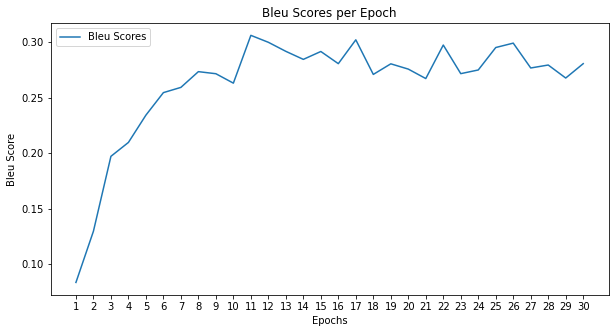

In [15]:
plt.figure(figsize=(10,5))
plt.title("Bleu Scores per Epoch")
x = np.arange(1, len(bleuScores1) + 1)
plt.xticks(x)
plt.plot(x, bleuScores1, label="Bleu Scores")
plt.xlabel("Epochs")
plt.ylabel("Bleu Score")
plt.legend()
plt.show()

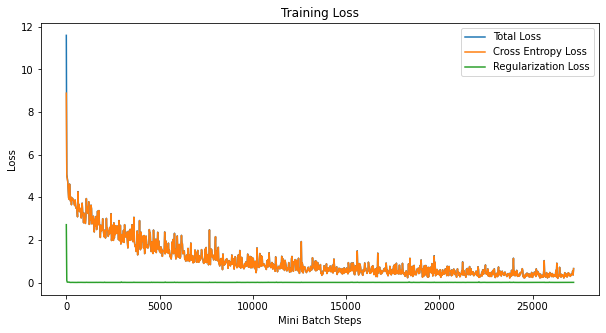

In [55]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
jump = 25
x = np.arange(0, len(CELosses1), jump)
plt.plot(x, losses1[::jump], label="Total Loss")
plt.plot(x, CELosses1[::jump], label="Cross Entropy Loss")
plt.plot(x, regLosses1[::jump], label="Regularization Loss")
plt.xlabel("Mini Batch Steps")
plt.ylabel("Loss")
# plt.ylim([0, 10])
plt.legend()
plt.show()

In [17]:
# We're ready to define everything we need for training our Seq2Seq model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {torch.cuda.get_device_name(0)}")

# Training Hyperparameters
num_epochs = 30
learning_rate = 3e-4
batch_size = 32

# Model Hyperparameters
src_vocab_size = len(german.vocab)
trg_vocab_size = len(english.vocab)
embedding_size = 512
num_heads = 4
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 50
forward_expansion = 2048
src_pad_idx = english.vocab.stoi["<pad>"]


# Regularization term
lam = 1.0

static_k = None
static_v = None

Current Device: NVIDIA GeForce GTX 1080 Ti


In [18]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data, test_data),
    batch_size=batch_size,
    sort_within_batch = True,
    sort_key = lambda x: len(x.src),
    device = device)

In [19]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [20]:
##### REGISTER HOOK
# Inputs to the 3 Encoder Layers
model.src_word_embedding.register_forward_hook(get_features('E1a'))
model.src_position_embedding.register_forward_hook(get_features('E1b'))
model.transformer.encoder.layers[0].register_forward_hook(get_features('E2'))
model.transformer.encoder.layers[1].register_forward_hook(get_features('E3'))

In [21]:
sentence = "ein pferd geht unter einer brücke neben einem boot."

losses = []
CELosses = []
regLosses = []
bleuScores = []

# Place holder for hooks
features = {}

for epoch in range(num_epochs):
    print(f"[Epoch {epoch + 1} / {num_epochs}]")

    model.eval()
    translated_sentence = translate_sentence(model, sentence, german, english, device, max_length=50)
    print(f"Translated example sentence: \n {translated_sentence}")
        
    model.train()   
    for batch_idx, batch in tqdm(enumerate(train_iterator)):       
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)
        
        # Place holder for hooks
        # placeholders
        INPUTS = []
        features = {}

        # Forward prop
        output = model(inp_data, target[:-1, :])
        
        # Store the inputs to the Encoder layers
        INPUTS.append(features['E1a'])
        INPUTS.append(features['E1b'])
        INPUTS.append(features['E2'])
        INPUTS.append(features['E3'])
    


        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin.
        # Let's also remove the start token while we're at it
        output = output.reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()

#         reg_penalty = torch.tensor(0)
        cross_entropy_loss = criterion(output, target)
        
        #####################################################################################
        # We will calculate the multi head attention matricies here and push for DIVERSITY! #
        #####################################################################################
        reg_penalty = calc_encoder_reg_error(inp_data.shape[1])
        #####################################################################################
        
        
        loss = cross_entropy_loss

        CELosses.append(cross_entropy_loss.item())
        regLosses.append(lam * reg_penalty.cpu().detach())
        losses.append(loss.item())

        # Back prop
        loss.backward()
        
        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()
        
    # running bleu on entire test data takes a while
    score = bleu(test_data[1:100], model, german, english, device)
    print(f"Bleu score {score * 100:.2f}")
    bleuScores.append(score)
        

[Epoch 1 / 30]
Translated example sentence: 
 ['lingerie', 'lingerie', 'unhappy', 'push', 'boat', 'blow', 'push', 'poodle', 'push', 'push', 'hairy', 'push', 'whom', 'push', 'hairy', 'pout', 'push', 'poodle', 'push', 'boat', 'biker', 'boat', 'push', 'hairy', 'push', 'hairy', 'pout', 'push', 'push', 'hairy', 'pout', 'fire', 'push', 'boat', 'push', 'boat', 'push', 'push', 'push', 'push', 'push', 'boat', 'biker', 'boat', 'pout', 'push', 'boat', 'boat', 'push', 'boat']


0it [00:00, ?it/s]

Bleu score 15.20
[Epoch 2 / 30]
Translated example sentence: 
 ['a', 'person', 'walks', 'next', 'to', 'a', 'snowy', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 23.16
[Epoch 3 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 24.51
[Epoch 4 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.07
[Epoch 5 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.39
[Epoch 6 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.10
[Epoch 7 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'underneath', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 31.63
[Epoch 8 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.12
[Epoch 9 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.48
[Epoch 10 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 34.06
[Epoch 11 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.80
[Epoch 12 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 33.82
[Epoch 13 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.69
[Epoch 14 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'under', 'a', 'bridge', 'near', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.47
[Epoch 15 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 31.53
[Epoch 16 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 31.67
[Epoch 17 / 30]
Translated example sentence: 
 ['a', 'horse', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.43
[Epoch 18 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.74
[Epoch 19 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.69
[Epoch 20 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.67
[Epoch 21 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 29.17
[Epoch 22 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'under', 'a', 'bridge', 'under', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.70
[Epoch 23 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'under', 'a', 'bridge', 'next', 'to', 'a', 'boat', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 33.18
[Epoch 24 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.03
[Epoch 25 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.95
[Epoch 26 / 30]
Translated example sentence: 
 ['a', 'horse', 'walks', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.59
[Epoch 27 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 30.97
[Epoch 28 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.40
[Epoch 29 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 31.04
[Epoch 30 / 30]
Translated example sentence: 
 ['a', 'horse', 'is', 'walking', 'beside', 'a', 'boat', 'under', 'a', 'bridge', '.', '<eos>']


0it [00:00, ?it/s]

Bleu score 32.75


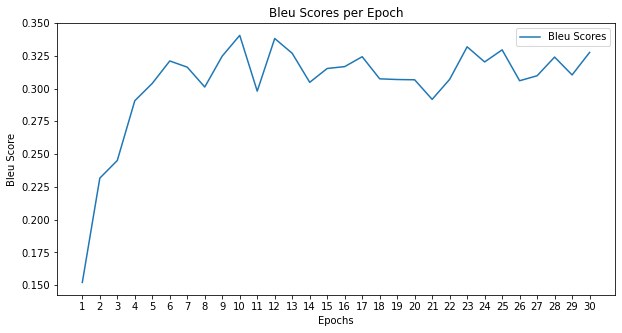

In [22]:
plt.figure(figsize=(10,5))
plt.title("Bleu Scores per Epoch")
x = np.arange(1, len(bleuScores) + 1)
plt.xticks(x)
plt.plot(x, bleuScores, label="Bleu Scores")
plt.xlabel("Epochs")
plt.ylabel("Bleu Score")
plt.legend()
plt.show()

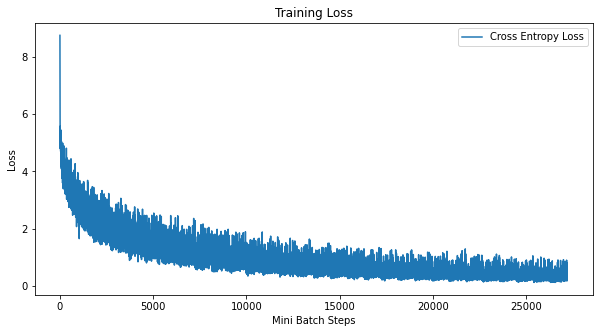

In [23]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(CELosses,label="Cross Entropy Loss")
plt.xlabel("Mini Batch Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

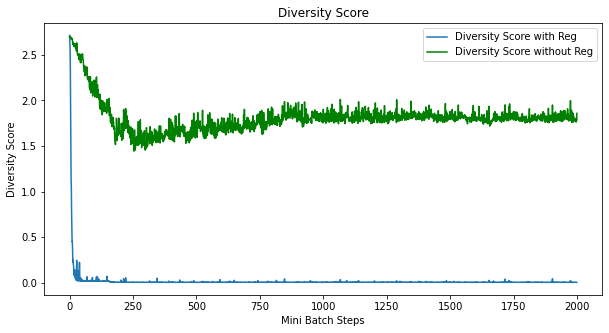

In [58]:
plt.figure(figsize=(10,5))
plt.title("Diversity Score")
jump = 1
x = np.arange(0, len(CELosses1), jump)
plt.plot(regLosses1[:2000:jump], label="Diversity Score with Reg")
plt.plot(regLosses[:2000:jump], label="Diversity Score without Reg", color="green")

plt.xlabel("Mini Batch Steps")
plt.ylabel("Diversity Score")
# plt.ylim([0, 40])
plt.legend()
plt.show()

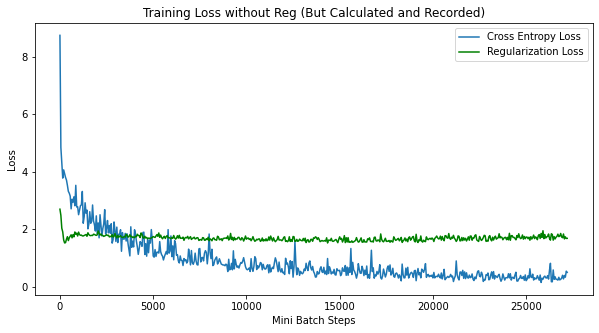

In [61]:
plt.figure(figsize=(10,5))
plt.title("Training Loss without Reg (But Calculated and Recorded)")
jump = 50
x = np.arange(0, len(losses), jump)
# plt.plot(x, losses[::jump], label="Total Loss")
plt.plot(x, CELosses[::jump], label="Cross Entropy Loss")
plt.plot(x, regLosses[::jump], label="Regularization Loss", color="green")
plt.xlabel("Mini Batch Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

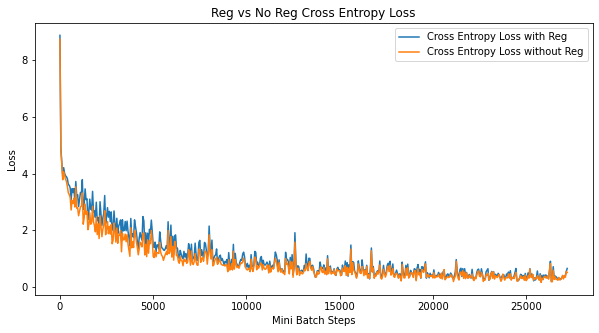

In [26]:
plt.figure(figsize=(10,5))
plt.title("Reg vs No Reg Cross Entropy Loss")
jump = 50
x = np.arange(0, len(CELosses1), jump)
plt.plot(x, CELosses1[::jump],label="Cross Entropy Loss with Reg")
plt.plot(x, CELosses[::jump],label="Cross Entropy Loss without Reg")
plt.xlabel("Mini Batch Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

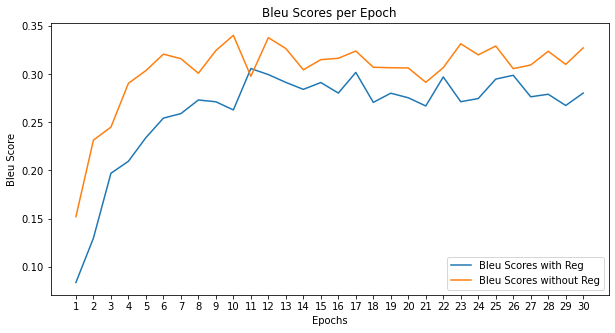

In [27]:
plt.figure(figsize=(10,5))
plt.title("Bleu Scores per Epoch")
x = np.arange(1, len(bleuScores1) + 1)
plt.xticks(x)
plt.plot(x, bleuScores1, label="Bleu Scores with Reg")
plt.plot(x, bleuScores, label="Bleu Scores without Reg")
plt.xlabel("Epochs")
plt.ylabel("Bleu Score")
plt.legend()
plt.show()

### Note

This code was based off an implementation by the Youtube Channel: Aladdin Person

(The github repo https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/seq2seq_transformer/seq2seq_transformer.py)